In [100]:
# 0. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 0.1 全局路径配置（按你自己的文件名改）
DATA_DIR = Path("./Q1data")

CALENDAR_PATH = DATA_DIR / "20250615-London-calendar.csv"
LISTINGS_PATH = DATA_DIR / "20250615-London-listings.csv"

# 这里是刚才那个 Borough 租金 Excel（第一张截图那种，按 Borough）
RENT_EXCEL_PATH = DATA_DIR / "borough_rent_2024_07_2025_06.xlsx"

# 可选：住房存量 Excel（第三张截图），暂时可以不用
STOCK_EXCEL_PATH = DATA_DIR / "dwelling_stock_2024.xlsx"

# 商业化阈值
COMMERCIAL_AVAIL_THRESHOLD = 60   # available_nights > 60 = commercial STR
HOTEL_LIKE_OCC_THRESHOLD = 180    # occupied_nights > 180 = hotel-like

YEAR = 2024061520250614  # 只是打印提示用

# 画图样式
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10

In [101]:
#1.1 汇总 calendar → 每个 listing 的年度夜数
def summarise_calendar_streaming(path: Path,
                                 chunk_size: int = 200_000) -> pd.DataFrame:
    """
    把 calendar 文件里**所有日期**都当成一个分析窗口来汇总。
    适合你这种：文件本身日期范围 = 你要分析的时间段。
    """
    agg = {}

    for chunk in pd.read_csv(
        path,
        usecols=["listing_id", "date", "available"],
        chunksize=chunk_size
    ):
        chunk["date"] = pd.to_datetime(chunk["date"], errors="coerce")
        # ✅ 不再按年份过滤，直接用全部日期
        chunk["occupied"] = chunk["available"].map({"t": 0, "f": 1})

        grouped = chunk.groupby("listing_id")["occupied"].agg(
            occupied_nights="sum",
            total_nights="size"
        )

        for lid, row in grouped.iterrows():
            occ = int(row["occupied_nights"])
            tot = int(row["total_nights"])
            if lid in agg:
                prev_occ, prev_tot = agg[lid]
                agg[lid] = [prev_occ + occ, prev_tot + tot]
            else:
                agg[lid] = [occ, tot]

    summary = (
        pd.DataFrame
        .from_dict(agg, orient="index", columns=["occupied_nights", "total_nights"])
        .reset_index()
        .rename(columns={"index": "listing_id"})
    )

    summary["available_nights"] = summary["total_nights"] - summary["occupied_nights"]
    summary["occupancy_rate"] = summary["occupied_nights"] / summary["total_nights"]
    return summary

    """
    用 chunk 流式读取大 calendar.csv，按 listing_id 汇总：
      - occupied_nights: 当年被占用的夜数
      - total_nights: 当年有记录的总夜数
      - available_nights: 当年可预订的夜数
      - occupancy_rate: 出租率

    对应结构：
    - 后面所有“High availability / occupancy”
    - Commercial STR（available > 60）
    - Hotel-like（occupied > 180）
    的基础。
    汇总 calendar.csv 中在 start_date - end_date 范围内的 nightly data。

    返回：
      - occupied_nights
      - total_nights
      - available_nights
      - occupancy_rate

    """

In [102]:
#1.2 读取 listings & 清理价格

def load_listings(path: Path) -> pd.DataFrame:
    """
    读取 listings.csv，并尝试把 price 清理成数值。
    对应结构：
      - Entire-home share
      - Multi-listing hosts
      - STR revenue（price * occupied_nights）
    """
    df = pd.read_csv(path, low_memory=False)
    if "price" in df.columns:
        # InsideAirbnb price 通常像 "$120.00"，需要去掉符号
        df["price_clean"] = (
            df["price"]
            .astype(str)
            .str.replace("[$,£]", "", regex=True)
            .astype(float)
        )
    else:
        df["price_clean"] = np.nan
    return df

In [103]:
#1.3 合并 calendar + listings，并添加商业化相关 flag
def merge_calendar_listings(occ_summary: pd.DataFrame,
                            listings: pd.DataFrame) -> pd.DataFrame:
    """
    把每个 listing 的年度夜数与房源属性、房东信息合并。
    """
    cols_to_keep = [
        "id", "host_id", "room_type",
        "neighbourhood_cleansed",
        "neighbourhood_group_cleansed",  # 当作 borough 用（如果有）
        "latitude", "longitude",
        "number_of_reviews",
        "price_clean"
    ]
    cols_to_keep = [c for c in cols_to_keep if c in listings.columns]

    merged = occ_summary.merge(
        listings[cols_to_keep],
        left_on="listing_id",
        right_on="id",
        how="left"
    )
    return merged


In [104]:
def add_commercialisation_flags(df: pd.DataFrame,
                                commercial_avail: int = 60,
                                hotel_like_occ: int = 180) -> pd.DataFrame:
    """
    添加商业化相关的布尔变量：
      - is_entire_home: 是否整套房
      - commercial_STR: 可用天数 > 60（文献：commercial STR）
      - hotel_like: occupied_nights > 180（酒店化运营）
      - legal_but_commercial: 未违反 90 天（如果你有 violates_90day 列）但高度商业化

    对应结构：
      - Evidence 1, 3：Entire-home + High availability / occupancy
      - Commercialisation Matrix 的三个维度之一
    """
    df["is_entire_home"] = df["room_type"].eq("Entire home/apt")
    df["commercial_STR"] = df["available_nights"] > commercial_avail
    df["hotel_like"] = df["occupied_nights"] > hotel_like_occ

    if "violates_90day" in df.columns:
        df["legal_but_commercial"] = (~df["violates_90day"]) & df["commercial_STR"]
    else:
        df["legal_but_commercial"] = np.nan

    return df


In [105]:
#2. Entire-home share（对应：Evidence 1 偏离共享经济）
def compute_entire_home_stats(df: pd.DataFrame) -> dict:
    """
    计算：
      - 全市 entire-home 占比
      - 按 borough（neighbourhood_group_cleansed）计算占比（如果有该列）

    对应报告结构：
      - Evidence 1: Airbnb 是否偏离共享经济？
    """
    stats = {}
    mask_valid = df["room_type"].notna()
    total_listings = mask_valid.sum()

    entire = df["room_type"].eq("Entire home/apt")
    n_entire = entire.sum()
    share_entire = n_entire / total_listings if total_listings > 0 else np.nan

    stats["total_listings"] = int(total_listings)
    stats["n_entire"] = int(n_entire)
    stats["share_entire"] = share_entire

    # 按 borough
    if "neighbourhood_group_cleansed" in df.columns:
        by_borough = (
            df[mask_valid]
            .groupby("neighbourhood_group_cleansed")["room_type"]
            .agg(
                n_listings="count",
                n_entire=lambda s: (s == "Entire home/apt").sum()
            )
            .reset_index()
            .rename(columns={"neighbourhood_group_cleansed": "borough"})
        )
        by_borough["share_entire"] = by_borough["n_entire"] / by_borough["n_listings"]
        stats["by_borough"] = by_borough
    else:
        stats["by_borough"] = None

    return stats

In [106]:
#3. Multi-listing hosts（对应：Evidence 2 专业房东 / 市场结构）
def compute_host_structure(df: pd.DataFrame) -> dict:
    """
    计算市场结构：
      - 每个 host 拥有多少 listing
      - multi-host（>=2） share
      - multi-host 控制的 listing 占比
      - top 10%、1% host 控制的 listing 占比（Optional 加分点 1）

    对应报告结构：
      - Evidence 2: 专业房东主导 & 市场结构不均衡
    """
    # 只考虑有 host_id 的
    valid = df["host_id"].notna()
    host_counts = (
        df[valid]
        .groupby("host_id")["listing_id"]
        .nunique()
        .sort_values(ascending=False)
    )

    total_hosts = host_counts.shape[0]
    total_listings = df["listing_id"].nunique()

    multi_host = host_counts[host_counts >= 2]
    n_multi_hosts = multi_host.shape[0]
    listing_by_multi = df[df["host_id"].isin(multi_host.index)]["listing_id"].nunique()

    # host 顶部 10%、1%
    def top_fraction_share(h_counts, fraction):
        n_top = max(1, int(len(h_counts) * fraction))
        top_hosts = h_counts.head(n_top).index
        n_listings_top = df[df["host_id"].isin(top_hosts)]["listing_id"].nunique()
        return n_listings_top / total_listings if total_listings > 0 else np.nan

    top10_share = top_fraction_share(host_counts, 0.10)
    top1_share = top_fraction_share(host_counts, 0.01)

    stats = {
        "total_hosts": int(total_hosts),
        "total_listings": int(total_listings),
        "n_multi_hosts": int(n_multi_hosts),
        "share_multi_hosts": n_multi_hosts / total_hosts if total_hosts > 0 else np.nan,
        "listing_by_multi": int(listing_by_multi),
        "share_listing_by_multi": listing_by_multi / total_listings if total_listings > 0 else np.nan,
        "share_listing_top10pct_hosts": top10_share,
        "share_listing_top1pct_hosts": top1_share,
        "host_counts": host_counts,
    }
    return stats

In [107]:
#4.1 统计 commercial STR / hotel-like STR
def compute_availability_stats(df: pd.DataFrame) -> dict:
    """
    针对整套房 is_entire_home，计算：
      - commercial_STR 占比（available_nights > 60）
      - hotel_like 占比（occupied_nights > 180）
      - legal_but_commercial 占比（如果有 violates_90day）

    对应结构：
      - Evidence 3: 酒店化运营
      - “合法但商业化”规避监管（Optional 加分点 3）
    """
    entire = df[df["is_entire_home"]].copy()
    n_entire = entire["listing_id"].nunique()

    commercial = entire["commercial_STR"].sum()
    hotel_like = entire["hotel_like"].sum()

    stats = {
        "n_entire": int(n_entire),
        "n_commercial_STR": int(commercial),
        "share_commercial_STR": commercial / n_entire if n_entire > 0 else np.nan,
        "n_hotel_like": int(hotel_like),
        "share_hotel_like": hotel_like / n_entire if n_entire > 0 else np.nan,
    }

    if "legal_but_commercial" in entire.columns:
        legal_but = entire["legal_but_commercial"].sum()
        stats["n_legal_but_commercial"] = int(legal_but)
        stats["share_legal_but_commercial"] = legal_but / n_entire if n_entire > 0 else np.nan

    return stats

In [108]:
#4.2 商业化矩阵（Entire + Multi-host + Commercial）
def compute_commercialisation_matrix(df: pd.DataFrame,
                                     host_structure_stats: dict) -> dict:
    """
    构造“商业化矩阵”：三个指标的交叉：
      - is_entire_home
      - host 是否 multi-host
      - commercial_STR

    识别：
      - entire only
      - entire + multi-host
      - entire + commercial
      - entire + multi-host + commercial（准酒店运营者）

    对应结构：
      - Evidence 4: Commercialisation Matrix
    """
    # 先根据 host_counts 判断谁是 multi-host
    host_counts = host_structure_stats["host_counts"]
    multi_host_ids = host_counts[host_counts >= 2].index

    df = df.copy()
    df["is_multi_host"] = df["host_id"].isin(multi_host_ids)

    entire = df[df["is_entire_home"]].copy()
    n_entire = entire["listing_id"].nunique()

    def count_condition(mask):
        return entire[mask]["listing_id"].nunique()

    n_entire_only = count_condition(~entire["is_multi_host"] & ~entire["commercial_STR"])
    n_entire_multi = count_condition(entire["is_multi_host"] & ~entire["commercial_STR"])
    n_entire_commercial = count_condition(~entire["is_multi_host"] & entire["commercial_STR"])
    n_entire_multi_commercial = count_condition(entire["is_multi_host"] & entire["commercial_STR"])

    matrix = {
        "n_entire_total": int(n_entire),
        "n_entire_only": int(n_entire_only),
        "n_entire_multi": int(n_entire_multi),
        "n_entire_commercial": int(n_entire_commercial),
        "n_entire_multi_commercial": int(n_entire_multi_commercial),
    }
    # 转成 share（方便写报告）
    for key in list(matrix.keys()):
        if key.startswith("n_") and key != "n_entire_total":
            share_key = key.replace("n_", "share_")
            matrix[share_key] = matrix[key] / n_entire if n_entire > 0 else np.nan

    return matrix

In [109]:
#5 STR Revenue Estimate（对应：Evidence 5 收益差）
def compute_str_revenue(df: pd.DataFrame) -> pd.DataFrame:
    """
    估算 STR 年度收益 & 月均收益：
      - str_revenue = price_clean * occupied_nights
      - monthly_str = str_revenue / 12

    对应结构：
      - Evidence 5: STR Revenue / Substitution incentive
    """
    df = df.copy()
    if "price_clean" not in df.columns:
        df["price_clean"] = np.nan

    df["str_revenue"] = df["price_clean"] * df["occupied_nights"]
    df["monthly_str"] = df["str_revenue"] / 12.0
    return df


In [110]:
#5.1
def compare_str_with_rent(df: pd.DataFrame,
                          rent_df: pd.DataFrame,
                          borough_col: str = "neighbourhood_group_cleansed") -> pd.DataFrame:
    """
    把 STR 估算收益与 GLA 租金对接：
      - 按 borough 计算 median monthly STR income
      - 与 median private rent 对比，算出 ratio

    对应结构：
      - Evidence 5: STR 收益 >> LTR 收益 的替代效应
    """
    if borough_col not in df.columns:
        raise ValueError(f"{borough_col} not found in df.")

    # 只看整套房，且有 monthly_str
    subset = df[df["is_entire_home"] & df["monthly_str"].notna()].copy()

    by_borough = (
        subset.groupby(borough_col)["monthly_str"]
        .median()
        .reset_index()
        .rename(columns={borough_col: "borough", "monthly_str": "median_str_monthly"})
    )

    rent_df = rent_df.rename(columns={"borough": "borough", "median_rent": "median_ltr_rent"})
    merged = by_borough.merge(rent_df, on="borough", how="left")
    merged["str_to_ltr_ratio"] = merged["median_str_monthly"] / merged["median_ltr_rent"]
    return merged

In [111]:
#6
def compute_str_density(df: pd.DataFrame,
                        stock_df: pd.DataFrame,
                        borough_col: str = "neighbourhood_group_cleansed") -> pd.DataFrame:
    """
    计算 STR density：
      STR per 1,000 dwellings = (# Airbnb listings in borough / housing_stock) * 1000

    对应结构：
      - Evidence 6: STR density & spatial housing pressure
    """
    if borough_col not in df.columns:
        raise ValueError(f"{borough_col} not found in df.")

    listings_by_borough = (
        df.groupby(borough_col)["listing_id"]
        .nunique()
        .reset_index()
        .rename(columns={borough_col: "borough", "listing_id": "n_airbnb"})
    )

    stock_df = stock_df.rename(columns={"borough": "borough", "housing_stock": "n_dwellings"})
    merged = listings_by_borough.merge(stock_df, on="borough", how="left")
    merged["str_density_per_1000"] = merged["n_airbnb"] / merged["n_dwellings"] * 1000.0
    return merged

In [112]:
7 
def plot_host_distribution(host_structure_stats: dict):
    """
    图 1：Host distribution（专业 vs 业余）

    x 轴：host 拥有的 listing 数
    y 轴：host 数量

    对应结构：
      - 可视化 1：揭示市场不平等（专业化）
    """
    host_counts = host_structure_stats["host_counts"]

    plt.figure()
    host_counts.value_counts().sort_index().plot(kind="bar")
    plt.xlabel("Number of listings per host")
    plt.ylabel("Number of hosts")
    plt.title("Host size distribution (market structure)")
    plt.tight_layout()
    plt.show()


In [113]:
def plot_availability_distribution(df: pd.DataFrame):
    """
    图 2：Annual availability distribution（只看整套房）

    对应结构：
      - 可视化 2：大量 listing 年开放 >60 / 出租 >180
    """
    entire = df[df["is_entire_home"]]
    plt.figure()
    plt.hist(entire["available_nights"].dropna(), bins=40)
    plt.xlabel("Available nights in year")
    plt.ylabel("Number of entire-home listings")
    plt.title("Distribution of annual availability (entire homes)")
    plt.tight_layout()
    plt.show()


In [114]:
def plot_commercial_str_by_borough(df: pd.DataFrame,
                                   borough_col: str = "neighbourhood_group_cleansed"):
    """
    图 3：按 borough 的 commercial_STR 占比（条形图版）

    对应结构：
      - 可视化 3：Commercial STR by borough（空间集中）
    """
    if borough_col not in df.columns:
        print(f"{borough_col} not found; skipping borough plot.")
        return

    entire = df[df["is_entire_home"]]
    grouped = (
        entire.groupby(borough_col)["commercial_STR"]
        .agg(
            n_entire="size",
            n_commercial="sum"
        )
        .reset_index()
        .rename(columns={borough_col: "borough"})
    )
    grouped["share_commercial"] = grouped["n_commercial"] / grouped["n_entire"]

    grouped = grouped.sort_values("share_commercial", ascending=False)

    plt.figure(figsize=(8, 6))
    plt.barh(grouped["borough"], grouped["share_commercial"])
    plt.xlabel("Share of commercial STR (entire homes)")
    plt.ylabel("Borough")
    plt.title("Commercial STR share by borough")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [115]:
def plot_str_vs_rent(str_vs_rent_df: pd.DataFrame):
    """
    图 4：STR revenue vs borough rent（散点图）

    对应结构：
      - 可视化 4：收益差驱动替代效应（substitution incentive）
    """
    plt.figure()
    plt.scatter(str_vs_rent_df["median_ltr_rent"], str_vs_rent_df["median_str_monthly"])
    for _, row in str_vs_rent_df.iterrows():
        plt.text(row["median_ltr_rent"], row["median_str_monthly"], row["borough"], fontsize=7)
    plt.xlabel("Median long-term rent (GLA)")
    plt.ylabel("Median monthly STR income (Airbnb)")
    plt.title("Estimated STR income vs long-term rent by borough")
    plt.tight_layout()
    plt.show()


In [116]:
#8 
def run_commercial_analysis(load_rent: bool = False,
                            load_stock: bool = False):
    """
    一键执行“Part 2: Commercialisation”分析。

    对应你写好的结构：
      1. Entire-home share
      2. Multi-listing hosts（市场结构）
      3. High availability / hotel-like
      4. Commercialisation Matrix
      5. STR revenue estimate & 替代效应
      6. STR density（如果有 housing stock）
      7. 可视化（4 张图）

    参数：
      - load_rent: 如果你已经准备了 RENT_PATH，对比 STR vs LTR
      - load_stock: 如果你已有 STOCK_PATH，计算 STR density
    """
    print(f"=== Step 1: Calendar summary for year {YEAR} ===")
    occ_summary = summarise_calendar_streaming(CALENDAR_PATH)
    print("  Listings with calendar data:", len(occ_summary))

    print("=== Step 2: Load listings and merge ===")
    listings = load_listings(LISTINGS_PATH)
    merged = merge_calendar_listings(occ_summary, listings)
    merged = add_commercialisation_flags(merged,
                                         COMMERCIAL_AVAIL_THRESHOLD,
                                         HOTEL_LIKE_OCC_THRESHOLD)
    print("  Merged rows:", len(merged))

    print("=== Step 3: Entire-home statistics ===")
    entire_stats = compute_entire_home_stats(merged)
    print(f"  Entire-home share (city-wide): {entire_stats['share_entire']:.2%}")

    print("=== Step 4: Host structure ===")
    host_stats = compute_host_structure(merged)
    print(f"  Total hosts: {host_stats['total_hosts']}")
    print(f"  Multi-host share: {host_stats['share_multi_hosts']:.2%}")
    print(f"  Listings controlled by multi-hosts: {host_stats['share_listing_by_multi']:.2%}")
    print(f"  Listings controlled by top 10% hosts: {host_stats['share_listing_top10pct_hosts']:.2%}")
    print(f"  Listings controlled by top 1% hosts: {host_stats['share_listing_top1pct_hosts']:.2%}")

    print("=== Step 5: Availability & hotel-like STR ===")
    avail_stats = compute_availability_stats(merged)
    print(f"  Commercial STR share (entire homes): {avail_stats['share_commercial_STR']:.2%}")
    print(f"  Hotel-like STR share (entire homes): {avail_stats['share_hotel_like']:.2%}")
    if "share_legal_but_commercial" in avail_stats:
        val = avail_stats["share_legal_but_commercial"]
        if not np.isnan(val):
            print(f"  Legal but commercial (entire homes): {val:.2%}")

    print("=== Step 6: Commercialisation Matrix ===")
    matrix_stats = compute_commercialisation_matrix(merged, host_stats)
    print(f"  Entire homes (total): {matrix_stats['n_entire_total']}")
    print(f"  Entire-only share: {matrix_stats['share_entire_only']:.2%}")
    print(f"  Entire + multi-host share: {matrix_stats['share_entire_multi']:.2%}")
    print(f"  Entire + commercial share: {matrix_stats['share_entire_commercial']:.2%}")
    print(f"  Entire + multi-host + commercial (hotel-like operators) share: {matrix_stats['share_entire_multi_commercial']:.2%}")

    print("=== Step 7: STR revenue estimate ===")
    merged_with_rev = compute_str_revenue(merged)
    print("  Example: median monthly STR income (entire homes):",
          merged_with_rev[merged_with_rev["is_entire_home"]]["monthly_str"].median())

    str_vs_rent_df = None
    if load_rent:
        try:
            rent_df = pd.read_csv(RENT_PATH)  # 需要你事先准备列：borough, median_rent
            str_vs_rent_df = compare_str_with_rent(merged_with_rev, rent_df)
            print("  STR vs LTR rent comparison (first rows):")
            print(str_vs_rent_df.head())
        except FileNotFoundError:
            print("  RENT_PATH not found; skip STR vs rent comparison.")

    str_density_df = None
    if load_stock:
        try:
            stock_df = pd.read_csv(STOCK_PATH)  # 需要列：borough, housing_stock
            str_density_df = compute_str_density(merged_with_rev, stock_df)
            print("  STR density (first rows):")
            print(str_density_df.head())
        except FileNotFoundError:
            print("  STOCK_PATH not found; skip STR density.")

    print("=== Step 8: Plots ===")
    plot_host_distribution(host_stats)
    plot_availability_distribution(merged_with_rev)
    plot_commercial_str_by_borough(merged_with_rev)

    if str_vs_rent_df is not None:
        plot_str_vs_rent(str_vs_rent_df)

    print("=== Commercialisation analysis done. ===")

    return {
        "occ_summary": occ_summary,
        "merged": merged_with_rev,
        "entire_stats": entire_stats,
        "host_stats": host_stats,
        "availability_stats": avail_stats,
        "commercial_matrix": matrix_stats,
        "str_vs_rent": str_vs_rent_df,
        "str_density": str_density_df,
    }


=== Step 1: Calendar summary for year None ===
  Listings with calendar data: 93480
=== Step 2: Load listings and merge ===
  Merged rows: 93480
=== Step 3: Entire-home statistics ===
  Entire-home share (city-wide): 61.19%
=== Step 4: Host structure ===
  Total hosts: 43329
  Multi-host share: 16.70%
  Listings controlled by multi-hosts: 31.51%
  Listings controlled by top 10% hosts: 25.30%
  Listings controlled by top 1% hosts: 10.63%
=== Step 5: Availability & hotel-like STR ===
  Commercial STR share (entire homes): 50.69%
  Hotel-like STR share (entire homes): 69.37%
  Legal but commercial (entire homes): 0.00%
=== Step 6: Commercialisation Matrix ===
  Entire homes (total): 40112
  Entire-only share: 35.06%
  Entire + multi-host share: 14.25%
  Entire + commercial share: 19.76%
  Entire + multi-host + commercial (hotel-like operators) share: 30.93%
=== Step 7: STR revenue estimate ===
  Example: median monthly STR income (entire homes): 2494.9166666666665
=== Step 8: Plots ===


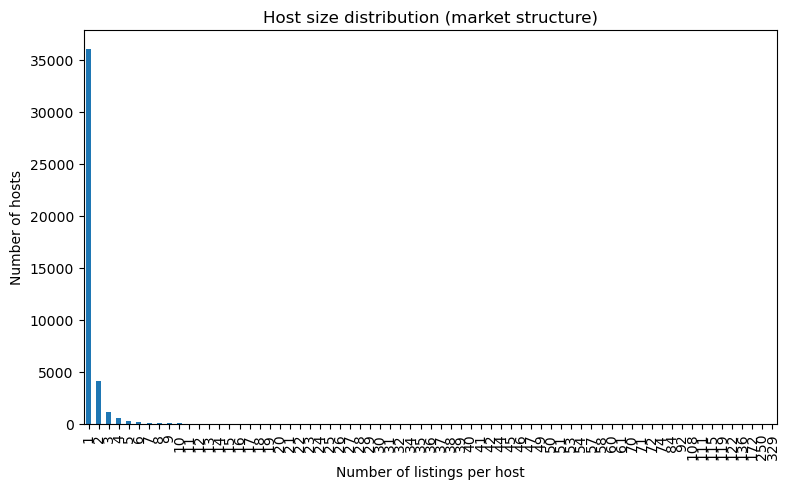

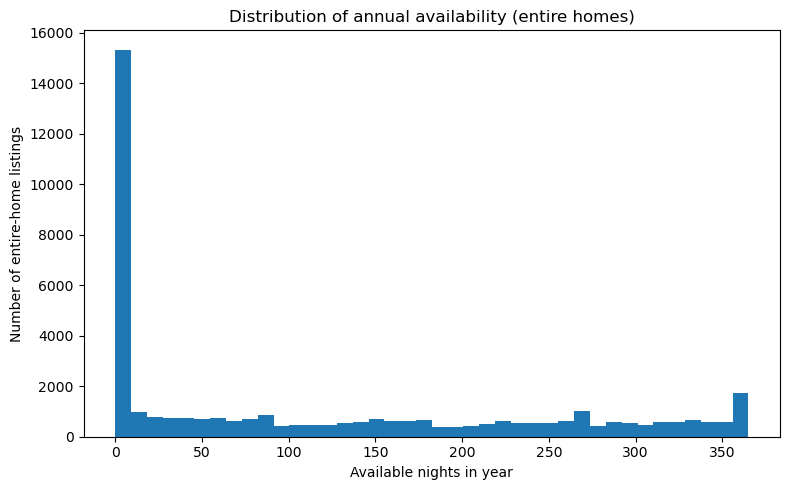

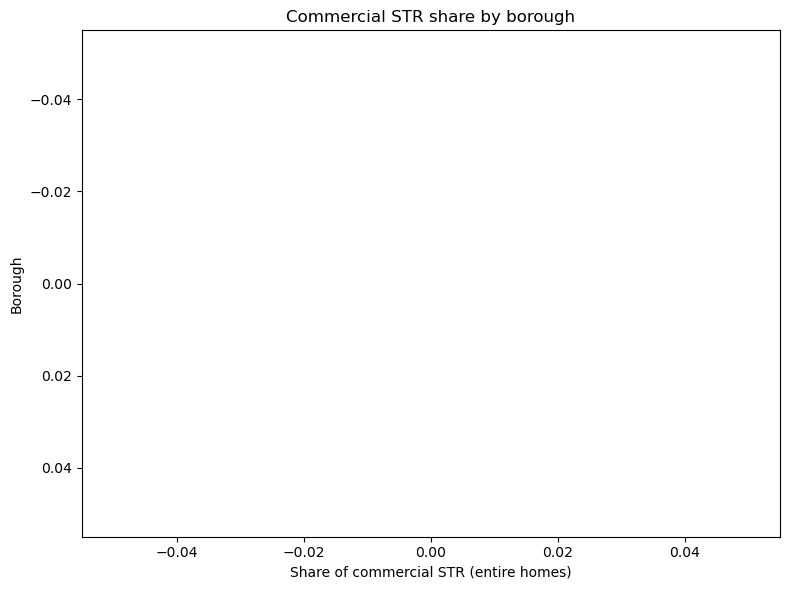

=== Commercialisation analysis done. ===


In [117]:
results_commercial = run_commercial_analysis(
    load_rent=False,   # 如果你已经准备了 borough 租金 CSV，就改成 True
    load_stock=False   # 如果你有 housing stock CSV，也改成 True
)